In [22]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
from matplotlib import gridspec

import time
import pickle
import re

import urllib.request
from bs4 import BeautifulSoup

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [23]:
mpl.__version__

'3.5.1'

In [24]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [25]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [27]:
plt.style.use("../matplotlib_style.txt")

# Import

In [28]:
# import clean_df_updated
clean_df_updated_reparsed_filtered = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 2147483648 bytes == 0x12c47dc000 @ 


In [29]:
all_abstracts = clean_df_updated_reparsed_filtered.AbstractText

In [30]:
tsne_reparsed = np.load(variables_path / "tsne_reparsed.npy")

In [31]:
tsne = np.vstack((-tsne_reparsed[:, 0], tsne_reparsed[:, 1])).T

In [32]:
mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")

In [33]:
mask_new_retracted_pmids = np.load(
    variables_path / "mask_new_retracted_pmids.npy"
)

# Fig 6: retracted papers

## Mentions in the abstract
We extract the papers that mention the following words ("retracted", "retraction", "withdrawal") in the abstract to exclude them from the plot. We want to highlight only retracted papers that do not explicitly state in their abstract that they have been retracted.

### Flagged in PubMed

In [34]:
abstracts = all_abstracts[mask_retracted_pmids]

In [35]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted)[0]),
)

Number of papers with uncapitalized word ' retracted':  160
Number of papers with capitalized word 'Retracted':  10
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  160


In [36]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction)[0]),
)

Number of papers with uncapitalized word ' retraction':  42
Number of papers with capitalized word 'Retraction':  12
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  46


In [37]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  43
Number of papers with capitalized word 'Withdrawal':  146
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  187


In [38]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  34
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  34


In [39]:
print(
    f"There are {np.sum((~mask_retraction)& (~mask_retracted)& (~mask_withdrawal)& (~mask_withdrawn))} intact papers"
)

There are 11756 intact papers


### New PMIDs from Retraction Watch

In [40]:
abstracts = all_abstracts[mask_new_retracted_pmids]

In [41]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_new)[0]),
)

Number of papers with uncapitalized word ' retracted':  85
Number of papers with capitalized word 'Retracted':  0
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  85


In [42]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_new)[0]),
)

Number of papers with uncapitalized word ' retraction':  55
Number of papers with capitalized word 'Retraction':  16
Number of papers with uppercased word 'RETRACTION':  1
Number of total papers with retraction:  60


In [43]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_new)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  44
Number of papers with capitalized word 'Withdrawal':  208
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  249


In [44]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_new)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  191
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  191


In [45]:
print(
    f"There are {np.sum((~mask_retraction_new)& (~mask_retracted_new)& (~mask_withdrawal_new)& (~mask_withdrawn_new))} intact papers"
)

There are 3572 intact papers


## Plot

In [50]:
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.linewidth"] = 0.5

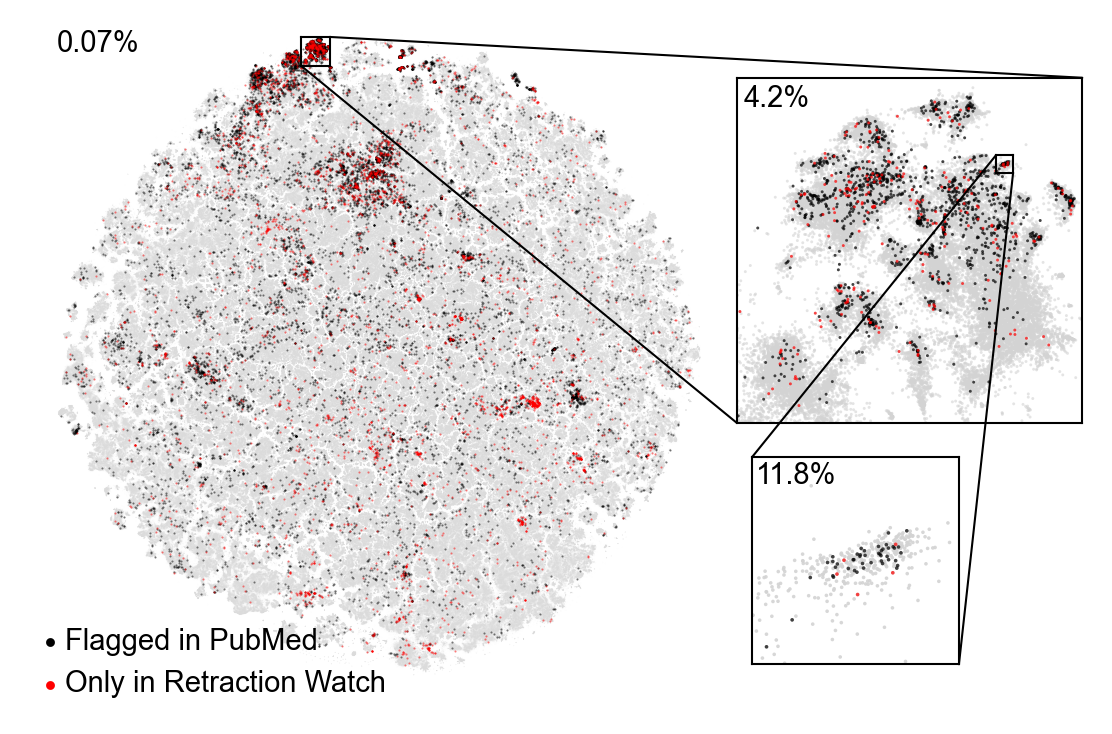

In [82]:
%matplotlib inline
fig = plt.figure(figsize=(3.6, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

## large embedding
ax0 = fig.add_axes([0.02, 0, 0.6, 1])  # [left, bottom, width, height]
x_lim = (-225, 225)
y_lim = (-225, 225)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

subregion_rw = tsne[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]

ax0.scatter(
    *tsne.T,
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)

ax0.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)

ax0.scatter(
    *subregion_rw.T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)
# fraction
ax0.text(
    0,
    1,
    f"{(subregion.shape[0] + subregion_rw.shape[0]) / tsne.shape[0] * 100:.2f}%",
    fontsize=7,
    transform=ax0.transAxes,
    va="top",
    ha="left",
)

# legend
legend_fontsize = 7
point1 = ax0.scatter(
    [], [], c="black", s=5, alpha=1, label="Flagged in PubMed"
)
point2 = ax0.scatter(
    [], [], c="red", s=5, alpha=1, label="Only in Retraction Watch"
)
ax0.legend(
    handles=[point1, point2],
    loc="lower left",
    fontsize=legend_fontsize,
    frameon=False,
    borderpad=0.2,
    handletextpad=0,
    handlelength=1,
    borderaxespad=-0.9,
)

ax0.axis("square")
ax0.set_xlim(x_lim[0], x_lim[1])
ax0.set_ylim(y_lim[0], y_lim[1])
ax0.axis("off")


## inset 1
ax1 = fig.add_axes([0.65, 0.4, 0.32, 0.5])  # [left, bottom, width, height]

right = -35
left = -55
top = 220
bottom = 200

s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_zoom_region_non_retracted = (  # for the fraction
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)
# fraction
ax1.text(
    0.02,
    0.98,
    f"{(np.sum(mask_grey) - np.sum(mask_zoom_region_non_retracted))/ np.sum(mask_grey)* 100:.1f}%",
    fontsize=7,
    transform=ax1.transAxes,
    va="top",
    ha="left",
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
ax1.set_xticks([])
ax1.set_yticks([])


# lines
c = "k"
lw = 0.5
ax0.plot([left, right], [top, top], linewidth=lw, c=c)
ax0.plot([left, right], [bottom, bottom], linewidth=lw, c=c)
ax0.plot([left, left], [bottom, top], linewidth=lw, c=c)
ax0.plot([right, right], [bottom, top], linewidth=lw, c=c)


ax0.annotate(
    "",
    xytext=(left, bottom),
    textcoords="data",
    xy=(0, 0),
    xycoords=ax1.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
)
ax0.annotate(
    "",
    xytext=(right, top),
    textcoords="data",
    xy=(1, 1),
    xycoords=ax1.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw),
)


## inset 2

ax2 = fig.add_axes([0.6, 0.05, 0.32, 0.3])  # [left, bottom, width, height]

right = -39
left = -40
top = 215.5
bottom = 214.5

# manually
s_grey = 3
s_color = 3
alpha_grey = 0.9
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax2.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)

mask_zoom_region_non_retracted = (  # for the fraction
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
    & (~mask_new_retracted_pmids)
)

mask_retracted_rw_zoom = (
    (subregion_rw[:, 0] < right)
    & (subregion_rw[:, 0] > left)
    & (subregion_rw[:, 1] < top)
    & (subregion_rw[:, 1] > bottom)
)

ax2.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax2.scatter(
    *subregion_rw[mask_retracted_rw_zoom].T,
    s=s_color,
    c="red",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

# fraction
ax2.text(
    0.02,
    0.98,
    f"{(np.sum(mask_grey) - np.sum(mask_zoom_region_non_retracted))/ np.sum(mask_grey)* 100:.1f}%",
    fontsize=7,
    transform=ax2.transAxes,
    va="top",
    ha="left",
)

ax2.axis("square")
ax2.set_xlim(left, right)
ax2.set_ylim(bottom, top)
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.axis("off")

# lines

c = "k"
lw = 0.5
ax1.plot([left, right], [top, top], linewidth=lw, c=c)
ax1.plot([left, right], [bottom, bottom], linewidth=lw, c=c)
ax1.plot([left, left], [bottom, top], linewidth=lw, c=c)
ax1.plot([right, right], [bottom, top], linewidth=lw, c=c)


# lw = 0.5
ax1.annotate(
    "",
    xytext=(left, top),
    textcoords="data",
    xy=(0, 1),
    xycoords=ax2.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(
        arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw, color="black"
    ),
)
ax1.annotate(
    "",
    xytext=(right, bottom),
    textcoords="data",
    xy=(1, 0),
    xycoords=ax2.transAxes,
    color="black",
    annotation_clip=False,
    arrowprops=dict(
        arrowstyle="-", shrinkA=0, shrinkB=0, linewidth=lw, color="black"
    ),
)


fig.savefig(
    figures_path / "fig_6_retracted_papers.png",
    dpi=500,
)
fig.savefig(
    figures_path / "fig_6_retracted_papers.pdf",
    dpi=500,
)

In [21]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False